<a href="https://colab.research.google.com/github/dcolbourne/Colab/blob/TensorFlow/07TransferLearninginTensorFlow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning



In [17]:
!nvidia-smi

Mon Jan  6 19:55:48 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              30W /  70W |   2173MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In [18]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-06 19:55:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-06 19:55:49 (75.1 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [19]:
# Import helper functions that we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

We'll use the pre-trained models from tf.keras.applications and apply them to our own problem.

https://www.tensorflow.org/api_docs/python/tf/keras/applications



In [20]:
# Get 10% of training data from the food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the data
unzip_data("10_food_classes_10_percent.zip")

--2025-01-06 19:55:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.1MB/s    in 8.9s    

2025-01-06 19:55:58 (18.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [21]:
# Check our how many images and sub dirs in our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [22]:
# Create training and test directory paths

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [23]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [24]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [25]:
# Check our the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [26]:
for images , labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[207.12755    170.12755     79.12755   ]
   [209.2143     169.2143      81.21428   ]
   [207.86224    166.29082     79.86224   ]
   ...
   [147.42346    122.423454    42.27039   ]
   [146.62245    121.62245     39.714268  ]
   [144.41327    119.41328     37.413277  ]]

  [[207.7602     170.7602      81.76021   ]
   [209.78572    169.78572     82.78571   ]
   [208.7143     167.14285     82.5       ]
   ...
   [146.57141    120.64284     43.428555  ]
   [145.         119.93369     40.13262   ]
   [144.2398     119.2398      39.2398    ]]

  [[205.42346    166.78061     82.42347   ]
   [209.7143     169.5         85.14286   ]
   [209.57144    167.7857      85.78571   ]
   ...
   [146.73979    123.95407     47.95407   ]
   [147.97453    125.18882     47.729607  ]
   [147.01021    124.224495    46.65307   ]]

  ...

  [[173.2142     126.280556    42.933643  ]
   [175.89787    127.469345    43.255085  ]
   [177.4949     126.87759     43.449036  ]
   ...
   [149.06126    129.632

## Model 0: Buidling a transfer learning model using keras functional API




In [27]:
# 1. Create a base mdoel with tf.keras.applications

from keras.applications.efficientnet_v2 import EfficientNetV2B0
import tensorflow as tf

base_model = EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (the underlying pretrained features are not upodates)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

#4. If your using ResNet50V2 you will need to normalize inputs (you don't have to for EffeicientNet)
# x =tf.keras.layers.experimental.preprocessing.Rescaling(1./225)(inputs)

# Pass the inputs to the model_0
x = base_model(inputs)
print(f"Shape after passing inputs through model_0: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x =  tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Cobine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                                  epochs=5,
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape after passing inputs through model_0: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250106-195606
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.2828 - loss: 2.0878 - val_accuracy: 0.7292 - val_loss: 1.3149
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 517ms/step - accuracy: 0.7360 - loss: 1.1978 - val_accuracy: 0.8100 - val_loss: 0.8967
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.8111 - loss: 0.8545 - val_accuracy: 0.8360 - val_loss: 0.7168
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.8468 - loss: 0.6994 - val_accuracy: 0.8468 - val_loss: 0.6254
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.8817 - loss: 0.6021 - val_accuracy: 0.8568 - val_loss: 0.5646


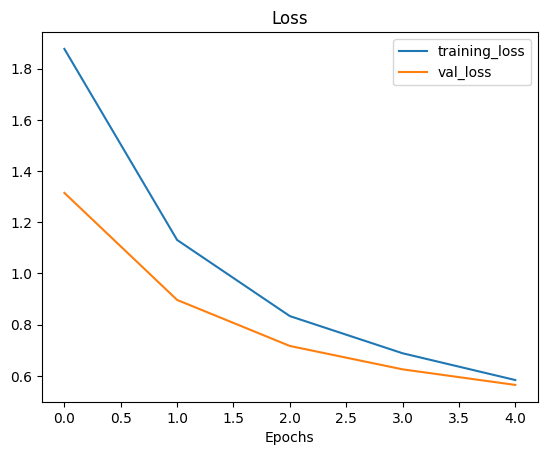

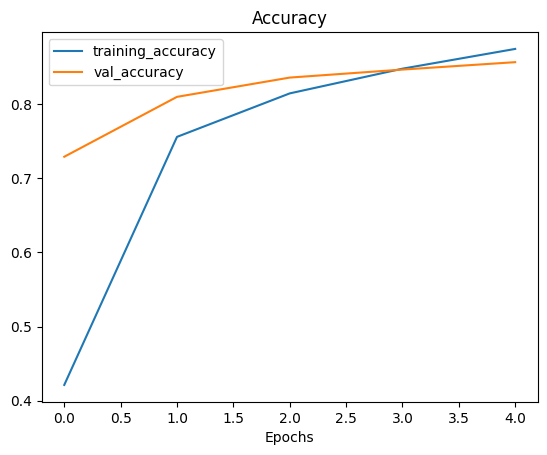

In [28]:
plot_loss_curves(history_0)

In [29]:
for layer_number, layer in enumerate(base_model.layers):
 print(layer_number, layer.name)

0 input_layer_3
1 rescaling_2
2 normalization_1
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_con

In [30]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, None, None, 3)  │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, None, None, 3)  │              0 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization) 

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [31]:
model_0.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [32]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8602 - loss: 0.5643


[0.5645524859428406, 0.8568000197410583]

## Getting a featue vector from a trained model

## Running a series of transfer learning experiments

How well does transger learning do with 1% of the data?

1. 'model_1' - use feature extraction transer learrning iwht 1% of the training data with data augmentation
2. 'model_2' - use feature extraction transfer learning with 10% of the training with data augmentation.UserWarning
3. 'model_3' - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmentation



In [33]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2025-01-06 19:58:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M  20.0MB/s    in 7.2s    

2025-01-06 19:58:17 (17.7 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [34]:
# Creat training and test dirs
train_dir_1_percent = "/content/10_food_classes_1_percent/train"
test_dir_1_percent = "/content/10_food_classes_1_percent/test"

In [35]:
# How many images
walk_through_dir("/content/10_food_classes_1_percent")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/i

In [36]:
# Setup data loaders
BATCH_SIZE = 32
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Augment the data in the model


print(tf.__version__)

We can use the layers inside:

* tf.keras.lyaers.experimental.preporocessing()

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.layers as layers

# Create data augmentation with horizontal flipping, rotations, zoom, etc.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip( "horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Efficienet automatically does rescaling
], name="data_augmentation")



### Visualize our data augmentation layer

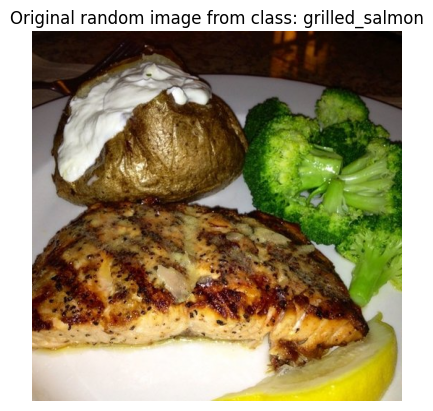

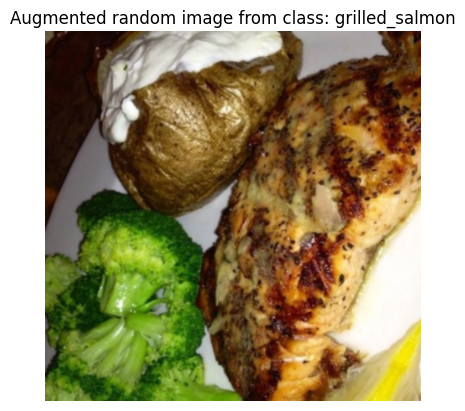

In [38]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Plot original image
plt.figure()
img = mpimg.imread(random_image_path)
plt.imshow(img/255.)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Plot our augmented image

plt.figure()
augmented_img = data_augmentation(img)
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model_1: Feaqture extraction transfer learning on 1% of the training data with data augmentation



In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.layers as layers

# Create data augmentation with horizontal flipping, rotations, zoom, etc.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip( "horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Efficienet automatically does rescaling
], name="data_augmentation")

# Setup input shape and base model, freezing the base layers models

input_shape =(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs =layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give the base_model the inputs (after augmentation)
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer
outputs = layers.Dense(10, activation="softmax", name ="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                        epochs=5,
                        validation_data=test_data_1_percent,
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/1_percent_feature_extraction/20250106-195821
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.0923 - loss: 2.3437 - val_accuracy: 0.1400 - val_loss: 2.2671
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.1645 - loss: 2.1217 - val_accuracy: 0.1988 - val_loss: 2.1608
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3420 - loss: 2.0270 - val_accuracy: 0.2636 - val_loss: 2.0736
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.4057 - loss: 1.8434 - val_accuracy: 0.3092 - val_loss: 1.9924
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.5833 - loss: 1.7130 - val_accuracy: 0.3660 - val_loss: 1.9181


In [40]:
model_1.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.3552 - loss: 1.9261


[1.9181240797042847, 0.3659999966621399]

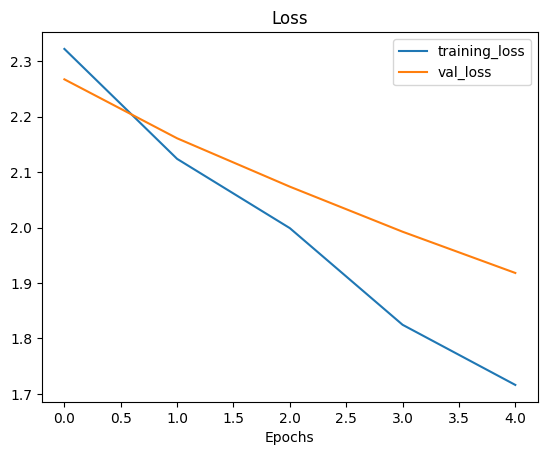

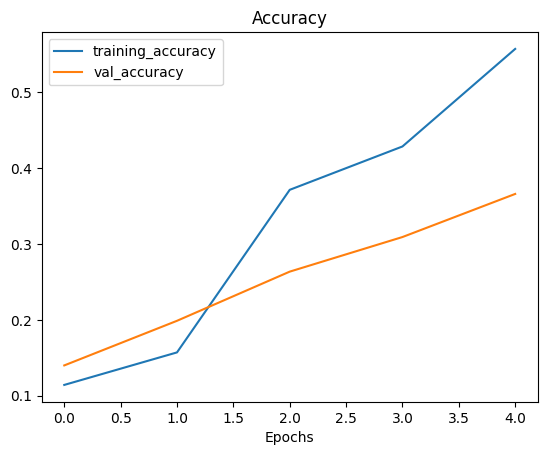

In [41]:
plot_loss_curves(history_1_percent)

In [42]:
## Modle 2: Feature extraction learning model with 10 percent data including augmentation

train_dir_10_percent = "/content/10_food_classes_10_percent/train"
test_dir_10_percent = "/content/10_food_classes_10_percent/test"

# Set up data inputs
import tensorflow as tf
from tensorflow.keras import layers
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras import layers
import tensorflow.keras.layers as layers

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

# Create data augmentation with horizontal flipping, rotations, zoom, etc.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip( "horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Efficienet automatically does rescaling
], name="data_augmentation")

input_shape = (224,224,3)
base_model = EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=(tf.keras.optimizers.Adam()),
                metrics=["accuracy"])




Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Create a ModelCheckpoint callback

In [43]:
# Set the checkpoint path

checkpoint_path = "ten_percent_model_checkpoints_weights/.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only = True,
                                                        save_best_only = True,
                                                        save_freq= 'epoch',
                                                        verbose=1)


In [44]:
# Fit the model
#initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = 5,
                                          validation_data=test_data,
                                          #validation_steps=(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                          experiment_name="10_percent_data_aug"),
                                          checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250106-195941
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.1741 - loss: 2.2383
Epoch 1: val_loss improved from inf to 1.57757, saving model to ten_percent_model_checkpoints_weights/.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 837ms/step - accuracy: 0.1787 - loss: 2.2311 - val_accuracy: 0.6028 - val_loss: 1.5776
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.5732 - loss: 1.5761
Epoch 2: val_loss improved from 1.57757 to 1.12510, saving model to ten_percent_model_checkpoints_weights/.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 664ms/step - accuracy: 0.5746 - loss: 1.5720 - val_accuracy: 0.7208 - val_loss: 1.1251
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6708 - loss: 1.2202
Epoch 3: val_loss improved from 1.12510 to 0.92006, saving model to ten_percent_model_checkpoints_weights/.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 854ms/step - accuracy: 0.6714 - loss: 1.2

In [45]:
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8110 - loss: 0.7084


[0.6968293190002441, 0.819599986076355]

In [46]:
# Check modle_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.8123 - loss: 0.7102


[0.6968294978141785, 0.819599986076355]

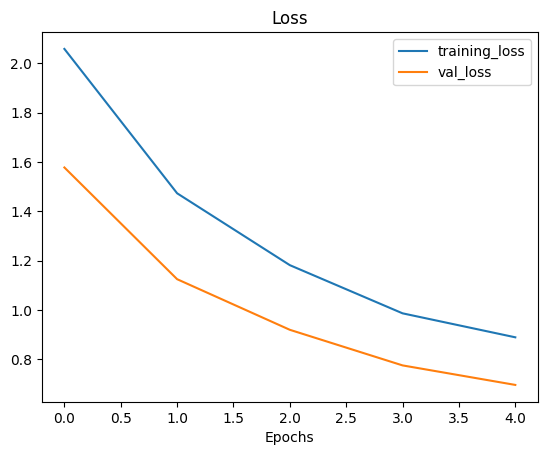

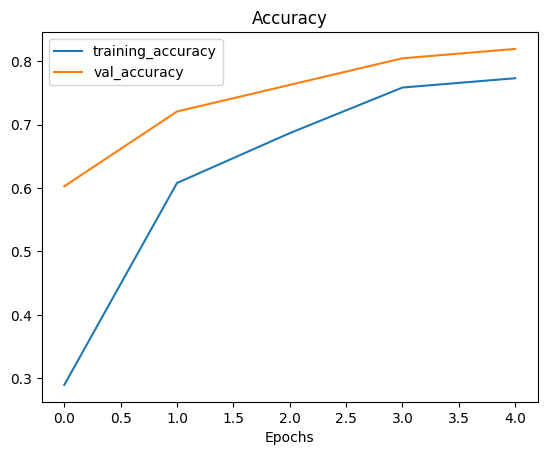

In [47]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

In [48]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)


In [49]:
loaded_weights_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8196 - loss: 0.6988


In [50]:
results_10_percent_data_aug == loaded_weights_results

False

In [51]:
results_10_percent_data_aug, loaded_weights_results


([0.6968294978141785, 0.819599986076355],
 [0.6968293190002441, 0.819599986076355])

In [52]:
# Check to see if they are very close
import numpy as np
np.isclose(results_10_percent_data_aug, loaded_weights_results)

array([ True,  True])

In [53]:
# Check difference
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_results))

[1.78813934e-07 0.00000000e+00]


In [58]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

  model_2.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(0.0001),
                  metrics=["accuracy"])

In [56]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_7 False
1 rescaling_5 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw